In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14, colour="black"),
 title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Need help getting started? Try the cookbook for R:
http://www.cookbook-r.com/Graphs/

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/pyth

In [3]:
%%R --o data_resp

data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")
data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
     # mutate(within_x=mean(pInGaze)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [5]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


#subj_group = data_resp.groupby(["pid", "Subject", "Time"])
subj_group = data_resp.groupby(["pid", "Subject"])

#subj_group = data_resp.groupby(["Time"])

dots_shown,dots_counted,pct_area,seen,n_look,times, pid=[],[],[],[],[],[], []
for i,subj in subj_group:
    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]*1.))
    dots_counted.append(list(subj["Dots_Counted"]*1.))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]*1.))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)
pid = remove_n(pid, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen
pid = np.array(pid)



with pm.Model() as mod:


    #beta_grp_sd = pm.HalfNormal("slope_grp_sd", sd=4,testval=2)
    #weber_grp_sd = pm.HalfNormal("weber_grp_sd",sd=1,testval=0.25)
    
    slope_grp_mu = pm.Normal("grp_slope_mu", mu=0, sd=5,testval=0)
    seen_slope_grp_mu = pm.Normal("seen_grp_slope_mu",mu=2, sd=1,testval=0.0)
    time_slope_grp_mu = pm.Normal("time_grp_slope_mu",mu=0, sd=10,testval=0.0)
   
    noise_grp_mu = pm.Normal("grp_noise_mu", mu=0, sd=5,testval=0)
    seen_noise_grp_mu = pm.Normal("seen_grp_noise_mu",mu=0, sd=10,testval=0.0)
    time_noise_grp_mu = pm.Normal("time_grp_noise_mu",mu=0, sd=10,testval=0.0)
    

    slope_grp_sd = pm.HalfNormal("grp_slope_sd", sd=10,testval=0.25)
    seen_slope_grp_sd = pm.HalfNormal("seen_grp_slope_sd",sd=10,testval=0.25)
    time_slope_grp_sd = pm.HalfNormal("time_grp_slope_sd",sd=10,testval=0.25)
    
    noise_grp_sd = pm.HalfNormal("grp_noise_sd", sd=10,testval=0.25)
    seen_noise_grp_sd = pm.HalfNormal("seen_grp_noise_sd",sd=10,testval=0.25)
    time_noise_grp_sd = pm.HalfNormal("time_grp_noise_sd",sd=10,testval=0.25)    
    #time_slope = pm.Normal("time_slope", mu=0, sd=10, shape=(len(dots_shown), 1))
    #beta_seen = pm.HalfNormal("beta_seen", sd=5, shape=(len(dots_shown), 1))
    #unseen_slope = pm.HalfNormal("unseen_slope", sd=1, testval=.1, shape=(len(dots_shown), 1))
    
    slope = pm.Normal("slope",slope_grp_mu, sd=slope_grp_sd, shape=(len(dots_shown), 1))
    noise = pm.Normal("noise", mu=noise_grp_mu, sd=noise_grp_sd, shape=(len(dots_shown), 1))
    seen_slope = pm.Normal("seen_slope",mu=seen_slope_grp_mu, sd=seen_slope_grp_sd, 
                                   shape=(len(dots_shown), 1), testval=0)
    seen_noise = pm.Normal("seen_noise",mu=seen_noise_grp_mu, sd=seen_noise_grp_sd, 
                                               shape=(len(dots_shown), 1), testval=0)
    time_slope = pm.Normal("time_slope",mu=time_slope_grp_mu, sd=time_slope_grp_sd, 
                                           shape=(len(dots_shown), 1), testval=0.)
    time_noise = pm.Normal("time_noise",mu=time_noise_grp_mu, sd=time_noise_grp_sd, 
                                       shape=(len(dots_shown), 1), testval=0.)

    #unseen_noise = pm.HalfNormal("unseen_noise", sd=5, shape=(len(dots_shown), 1))
    #unseen_noise = pm.Normal("unseen_noise", mu=1, sd=1, shape=(len(dots_shown), 1))
    #weber = (weber + abs(weber))/2. + 1e-8 #this removes negatives
    
    
    #guess_mean = beta * dots_shown + seen_slope * unseen
    guess_mean = dots_shown * tt.exp(slope + seen_slope * (seen/dots_shown) + time_slope*tt.log(times))  #unseen_slope * unseen

   # guess_mean = tt.exp(slope * dots_shown + seen_slope * seen)  #unseen_slope * unseen
    
    guess_sd = guess_mean * tt.exp((noise +  seen_noise * (seen/dots_shown) + time_noise*tt.log(times)))
    
    #guess_sd += dev_unseen * 
    
    lkhd = pm.Normal("lkhd", mu=guess_mean, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(100, tune=25, cores=2, njobs=2, chains=1)
    

    
    
    

summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (1 chains in 1 job)
NUTS: [time_noise, time_slope, seen_noise, seen_slope, noise, slope, time_grp_noise_sd_log__, seen_grp_noise_sd_log__, grp_noise_sd_log__, time_grp_slope_sd_log__, seen_grp_slope_sd_log__, grp_slope_sd_log__, time_grp_noise_mu, seen_grp_noise_mu, grp_noise_mu, time_grp_slope_mu, seen_grp_slope_mu, grp_slope_mu]
100%|██████████| 125/125 [00:07<00:00, 16.04it/s]
Only 100 samples in chain.
The acceptance probability does not match the target. It is 0.9313336840574464, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run so

                       mean        sd  mc_error   hpd_2.5  hpd_97.5
grp_slope_mu      -0.517901  0.105645  0.010564 -0.736011 -0.297265
seen_grp_slope_mu  0.410498  0.138961  0.013896  0.139455  0.689008
time_grp_slope_mu  0.000828  0.020637  0.002064 -0.036947  0.039129
grp_noise_mu      -0.954427  0.295194  0.029519 -1.472477 -0.565595
seen_grp_noise_mu -0.701026  0.438445  0.043844 -1.313900  0.033537
time_grp_noise_mu  0.055632  0.056361  0.005636 -0.041934  0.142933
slope__0_0        -0.555921  0.123052  0.012305 -0.757455 -0.312844
slope__1_0        -0.723296  0.104300  0.010430 -0.917959 -0.518912
slope__2_0        -0.401271  0.105890  0.010589 -0.565005 -0.156762
slope__3_0        -0.418645  0.093529  0.009353 -0.604676 -0.262803
slope__4_0        -0.437475  0.104483  0.010448 -0.655818 -0.246499
slope__5_0        -0.387965  0.100680  0.010068 -0.567798 -0.172883
slope__6_0        -0.517544  0.122949  0.012295 -0.729858 -0.281143
slope__7_0        -0.435932  0.104178  0.010418 

In [6]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    
    if 'grp' in rowname:
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group*n_groups)]

    else:
        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Time"] = np.ravel(times)
vals["seen"] = np.ravel(seen)

vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)


sum_vals=pd.DataFrame(vals)
#print(seen.shape)
pandas2ri.py2ri(sum_vals)

grp_slope_mu        -0.517901
seen_grp_slope_mu    0.410498
time_grp_slope_mu    0.000828
grp_noise_mu        -0.954427
seen_grp_noise_mu   -0.701026
time_grp_noise_mu    0.055632
slope__0_0          -0.555921
slope__1_0          -0.723296
slope__2_0          -0.401271
slope__3_0          -0.418645
slope__4_0          -0.437475
slope__5_0          -0.387965
slope__6_0          -0.517544
slope__7_0          -0.435932
slope__8_0          -0.389684
slope__9_0          -0.391851
slope__10_0         -0.671846
slope__11_0         -0.927524
slope__12_0         -0.934838
slope__13_0         -0.075506
slope__14_0         -0.283431
slope__15_0         -0.720397
slope__16_0         -0.462011
slope__17_0         -0.626004
slope__18_0         -0.484022
slope__19_0         -0.594223
slope__20_0         -0.473740
slope__21_0         -0.080772
slope__22_0         -0.509355
slope__23_0         -0.567635
                       ...   
time_noise__2_0      0.043382
time_noise__3_0      0.080859
time_noise

Dots_Counted,Dots_Shown,Time,...,time_slope_high,time_slope_low,time_slope_sd
20.000000,18.000000,0.330000,...,0.033320,-0.084125,0.030231
60.000000,89.000000,0.330000,...,0.033320,-0.084125,0.030231
30.000000,36.000000,0.330000,...,0.033320,-0.084125,0.030231
45.000000,86.000000,0.330000,...,0.033320,-0.084125,0.030231
...,...,...,...,...,...,...
35.000000,66.000000,1.000000,...,0.112748,0.023590,0.025447
35.000000,76.000000,1.000000,...,0.112748,0.023590,0.025447


[1] 0.0008284299
[1] 0.0391291
[1] -0.03694705
[1] ""
[1] 0.410498
[1] 0.6890079
[1] 0.1394549


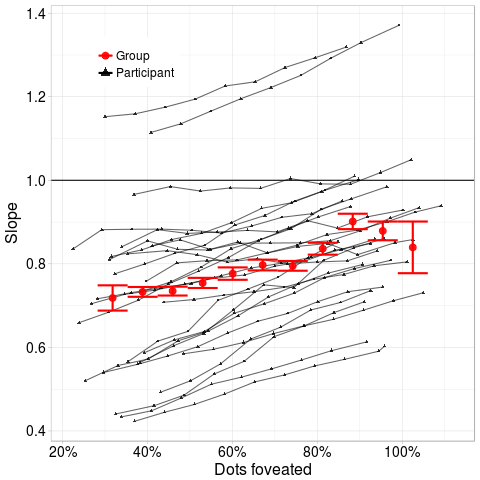

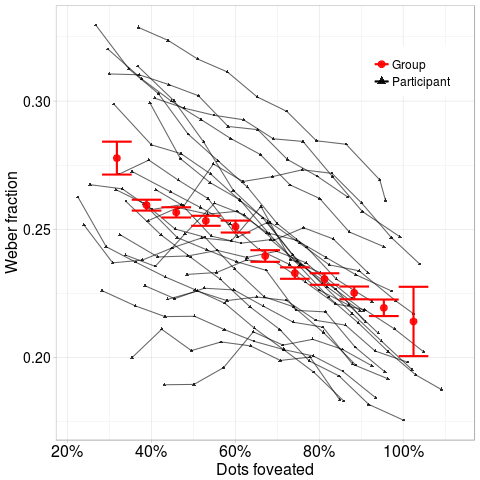

In [16]:
%%R -i sum_vals summary

sum_vals <- sum_vals %>% 
            mutate(time_num=Time) %>%
            mutate(Time=as.factor(Time)) %>%
            mutate(pct_seen=(seen)/Dots_Shown) %>%
            mutate(pct_err=(Dots_Counted-Dots_Shown)/Dots_Shown) %>%
             mutate(real_weber=exp(pct_seen * seen_noise + noise + log(time_num) * time_noise)) %>%
             mutate(real_slope=exp(pct_seen * seen_slope + slope + log(time_num)*time_slope)) %>%
             mutate(real_time_weber=exp(noise + log(time_num) * time_noise)) %>%
             mutate(real_time_slope=exp(slope + log(time_num)*time_slope)) %>%
            mutate(guess=real_slope * Dots_Shown) %>%
            mutate(noise=real_weber * guess) 



ylab1 <- expression(beta ["seen"])
ylab2 <- expression(sigma ["seen"])

p.1 <- ggplot(data=sum_vals, aes(x=pct_seen, y=(guess-Dots_Shown)/Dots_Shown,  color=Time)) +
        geom_jitter(alpha=0.2, width=0.0, height=0.05) +
      #  stat_summary_bin(bins=15, fun.y="mean", geom="point") +
        stat_smooth(method="lm", se=FALSE, size=1.5) +
        stat_smooth(method="lm", alpha=0.1) +

        paper_theme_2 + 
        xlab("%Seen") + ylab("%Error") +


        geom_hline(aes(yintercept=0.0)) + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +
        scale_x_continuous(labels = scales::percent)  +
        scale_y_continuous(labels = scales::percent)  



p.2 <- ggplot(data=sum_vals, aes(x=pct_seen, y=real_slope)) +
      #  geom_jitter(alpha=0.2, width=0.1, height=0.0) +
      stat_summary_bin(bins=10, fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary_bin(bins=10,fun.y="mean", geom="point", size=1,alpha=0.8, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

      # stat_summary_bin(bins=5,fun.data="mean_se", geom="errorbar", size=0.25, position=position_dodge(width=0.2),
            #        aes(group=pid, color="Participant", shape="Participant")) +

       stat_summary_bin(bins=10,geom="errorbar", width=0.3,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary_bin(bins=10,geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Slope") + xlab("Dots foveated")    +
      #  coord_cartesian(xlim=c(0.25,1.05)) +
                theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            legend.position=c(0.2,0.87),
                            axis.text.x=element_text(size=14),
                            axis.text.y=element_text(size=14),
                         axis.title.x=element_text(face="plain", size=16),
                            axis.title.y=element_text(face="plain", size=16)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank())  +
        scale_x_continuous(labels = scales::percent)   +
        geom_hline(yintercept=1.0)

#+
         #  facet_wrap(~paste(Time, "(s)"))
p.3 <- ggplot(data=sum_vals, aes(x=pct_seen, y=real_weber)) +
      #  geom_jitter(alpha=0.2, width=0.1, height=0.0) +
      stat_summary_bin(bins=10, fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary_bin(bins=10,fun.y="mean", geom="point", size=1,alpha=0.8, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

      # stat_summary_bin(bins=5,fun.data="mean_se", geom="errorbar", size=0.25, position=position_dodge(width=0.2),
            #        aes(group=pid, color="Participant", shape="Participant")) +

       stat_summary_bin(bins=10,geom="errorbar", width=0.3,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary_bin(bins=10,geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 +  theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            legend.position=c(0.85,0.85),
                            axis.text.x=element_text(size=14),
                            axis.text.y=element_text(size=14),
                         axis.title.x=element_text(face="plain", size=16),
                            axis.title.y=element_text(face="plain", size=16)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Weber fraction") + xlab("Dots foveated")    +
        #ylim(0,0.5) +
      #  coord_cartesian(xlim=c(-0.05,1.05), ylim=c(0.0,0.5)) + 
        theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank())  +
        scale_x_continuous(labels = scales::percent)  

p.4 <- ggplot(data=sum_vals, aes(x=Time, y=real_time_slope)) +
      #  stat_smooth(method="lm")
       stat_summary(fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary(fun.y="mean", geom="point",alpha=0.8, size=1.0, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +


        stat_summary(geom="errorbar", width=0.5,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain")) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +
            ylim(0.1,1.3) +

            ylab("Slope") + xlab("Time (s)")        #  geom_jitter(alpha=0.2, width=0.1, height=0.0) + 


#+
#print(p.1)
print(p.2)
ggsave("figs/seen_slope.png", width=5, height=5, dpi=300)

print(p.3)
ggsave("figs/seen_weber.png", width=5, height=5, dpi=300)

print(mean(sum_vals$time_grp_slope_m))
print(mean(sum_vals$time_grp_slope_m_high))
print(mean(sum_vals$time_grp_slope_m_low))
print("")
print(mean(sum_vals$seen_grp_slope_m))
print(mean(sum_vals$seen_grp_slope_m_high))
print(mean(sum_vals$seen_grp_slope_m_low))